In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hwk3-task1-spills.ipynb")

# Task 1: Visualizing oil spills in NY State

## Instructions

- First, update the following cell to have a link to *your* Homework 2 GitHub repository:

**UPDATE THIS LINK**
https://github.com/avarobillard/eds220-hwk3


- Review the [complete rubric for this task](https://docs.google.com/document/d/1x0BoU6IH4cnOR1-n7i9CYQ9wUC37yDpYlQ4j6rCfcsU/edit?tab=t.0) before starting.

- **Meaningful commits should be made every time you finish a major step.** We'll check your repository and view the commit history.

- Comment mindfully in a way that enriches your code. Comments should follow best practices.

- **Do not update the top cell with the `otter` import**, this is used internally for grading.


## About the data
In this task you will use two datsets:

### First dataset: oil spills data

The first dataset contains information about [spilling incidents in the state of New York](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk). 
The data portal has plenty of information. 
You will find extra information and metadata for this datset in the `NYSDEC_SpillIncidents_Overview.pdf` and `NYSDEC_SpillIncidents_DataDictionary.pdf` documents available at the portal.

### Second dataset: TIGER shapefile

The second dataset is the [the 2023 Counties (and equivalent) TIGER shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341) from the Census Bureau. You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 

## 1. File management
a. Create a `data/` directory inside your `eds220-hwk3` directory. If you download any data, it should be transferred into this folder. 

b. Add the `data/` directory to your `.gitignore` file and push your changes. This is IMPORTANT: the datasets we'll be working with are large and they will most likely jam your commit history if you try to push them.

## 2. Datasets description
- Read the metadata for both datsets and write a brief description about each one. Indicate the date sources and date of access.

**Oil spills data**: This dataset contains records of spills of petroleum and other hazardous materials in the state of New York. Each of the spill records includes are a unique seven-digit spill number, facility type, spill date/time, location, contributing factor, spill source and cause, materials spilled, quantity spilled and recovered, water bodies affected, and when the incident was closed. They receive about 15,000 reports annually, and the data is provided as collected even if incomplete or inaccurate. The data has a lot of context for correct use found in the Data Overview document, such as some spills having multiple rows for multiple material types.

- Citation: New York State Department of Environmental Conservation. (2025). Spill Incidents. NY Open Data. https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk/about_data. Accessed November 2, 2025.

**TIGER shapefile**: This shapefile contains the legal boundaries of U.S. counties and county equivalents for 2023, represented as polygons. The records are associated with a geographic entity code (GEOID) that can be linked to U.S. Census data. TIGER shapefiles include polygon boundaries of geographic areas and features, line features including roads and hydrography, and point features.

- Citation: 2023 TIGER/Line Shapefiles (machine- readable data files) / prepared by the U.S. Census Bureau, 2025. https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2023.html#list-tab-790442341.  Accessed November 2, 2025.

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds220-env/share/proj failed


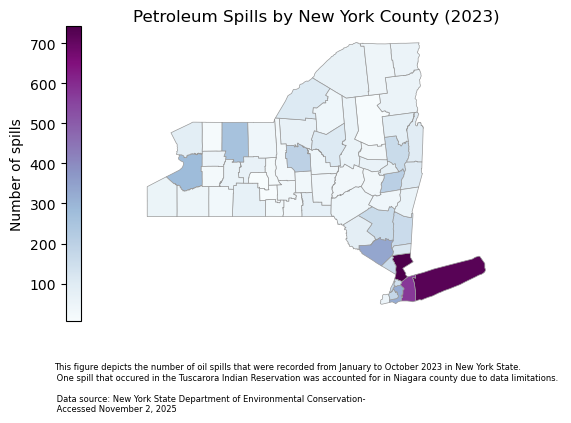

In [2]:
## COMPLETE WORKFLOW

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Load data
# Read in NY oil spills data
fp = os.path.join('data', 'Spill_Incidents_20251102.csv')
spills = pd.read_csv(fp)

# Read in US counties data
fp = os.path.join('data', 'tl_2023_us_county', 'tl_2023_us_county.shp')
counties = gpd.read_file(fp)

# Clean column names
# Convert spills column names to lowercase
spills.columns = spills.columns.str.lower()

# Replace spaces in spills column names with underscores
spills.columns = spills.columns.str.replace(' ', '_')

# Convert counties column names to lowercase
counties.columns = counties.columns.str.lower()


# Convert spill_date column to a datetime object for easier filtering
spills['spill_date'] = pd.to_datetime(spills['spill_date'])

# Filter data to petroleum spills between Jan 1 and Oct 31, 2023
petr_23 = spills[(spills.material_family == 'Petroleum') &
                 (spills.spill_date >= '2023-01-01') &
                 (spills.spill_date <= '2023-10-31')]

# Create new data frame for number of spills by county
spills_per_county = (petr_23.groupby('county')
                      .size()
                      .reset_index(name='n_spills'))

# Select the counties in New York using corresponding FIPS code
ny_counties = counties[counties['statefp'] == '36']

# Correct 'St Lawrence' to 'St. Lawrence' for a correct join
spills_per_county['county'] = spills_per_county['county'].replace('St Lawrence', 'St. Lawrence')


# Rename columns containing county names for inner join
ny_counties = ny_counties.rename(columns = {'name':'county'})

# Inner join to merge ny_counties and spills_per_county data frames
ny_counties = pd.merge(ny_counties,
                       spills_per_county,
                       how='inner',
                       on='county')


# Get index of row with Niagara county
n_index = ny_counties[ny_counties['county']=='Niagara'].index

# Update Niagara county spills by directly adding 1
ny_counties.loc[n_index, 'n_spills'] += 1


# Create choropleth map to visualize number of spills per county
fig, ax = plt.subplots()

ax.set_title("Petroleum Spills by New York County (2023)")
ax.axis("off")

# Plot merged data frame and color counties by n_spills
ny_counties.plot(ax=ax,
                column = 'n_spills',
                cmap = 'BuPu',
                legend = True,
                edgecolor = "0.6",
                linewidth = 0.5,
                legend_kwds = {
                    "label": "Number of spills",
                    "location": "left",
                    "shrink": 0.8
                }
                )

# Add data source
plt.figtext(0.2, 0, "This figure depicts the number of oil spills that were recorded from January to October 2023 in New York State. \n One spill that occured in the Tuscarora Indian Reservation was accounted for in Niagara county due to data limitations. \n \n Data source: New York State Department of Environmental Conservation- \n Accessed November 2, 2025", fontsize = 6)
plt.show()

## 3. Import libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

## 4. Import data 
In the next cell:

- Import the NY spills data as a variable named `spills`. 
- Import the US counties data as a variable named `counties`.

If you are using file paths to access the data, these should be constructed using the `os` package.

In [4]:
# Read in NY oil spills data
fp = os.path.join('data', 'Spill_Incidents_20251102.csv')
spills = pd.read_csv(fp)

# Read in US counties data
fp = os.path.join('data', 'tl_2023_us_county', 'tl_2023_us_county.shp')
counties = gpd.read_file(fp)

<!-- BEGIN QUESTION -->

## 5. Prepare spills data

This section refers to the `spills` dataframe. 
Check the outputs carefully, they will give you information you will need to use in the next exercises.

### 5.A. Exploration

In the next cells:

a. Check the dataframe's head

b. Check the data types of the columns

c. Check the unique values in the `material_family` column

d. Check the unique values in the `county` column

e. Insert a markdown cell to explain what information you obtained from the preliminary exploration. Use complete sentences.

You can add any other cells for preliminary data exploration.

In [5]:
#a. Check the dataframe's head

# Display first 5 rows of data
spills.head()

,Spill Number,Program Facility Name,Street 1,Street 2,Locality,County,ZIP Code,SWIS Code,DEC Region,Spill Date,Received Date,Contributing Factor,Waterbody,Source,Close Date,Material Name,Material Family,Quantity,Units,Recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,10/10/2001,10/10/2001,Unknown,NaN,Unknown,10/15/2001,unknown material,Other,10,Gallons,0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0,NaN,0
2,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0,Pounds,0
3,204667,POLE 16091,GRACE AVE/BURKE AVE,NaN,BRONX,Bronx,NaN,301,2,08/02/2002,08/02/2002,Equipment Failure,NaN,Commercial/Industrial,10/28/2002,transformer oil,Petroleum,1,Gallons,0
4,210559,POLE ON,FERDALE LOMIS RD / RT 52,NaN,LIBERTY,Sullivan,NaN,5336,3,01/20/2003,01/20/2003,Traffic Accident,NaN,Commercial/Industrial,01/22/2003,transformer oil,Petroleum,6,Gallons,6


In [6]:
#b. Check the data types of the columns

# Check the data type of each column in spills
print(spills.dtypes)

Spill Number              int64
Program Facility Name    object
Street 1                 object
Street 2                 object
Locality                 object
County                   object
ZIP Code                 object
SWIS Code                 int64
DEC Region                int64
Spill Date               object
Received Date            object
Contributing Factor      object
Waterbody                object
Source                   object
Close Date               object
Material Name            object
Material Family          object
Quantity                 object
Units                    object
Recovered                object
dtype: object


In [7]:
#c. Check the unique values in the `material_family` column

# Check the unique values in the 'Material Family' column of spills
print(spills['Material Family'].unique())

['Other' 'Petroleum' 'Hazardous Material' 'Oxygenates']


In [8]:
#d. Check the unique values in the `county` column

# Check the unique value in the 'County' column of spills 
print(spills['County'].unique())

['Westchester' 'Queens' 'Bronx' 'Sullivan' 'Cortland' 'New York' 'Ulster'
 'Kings' 'Orange' 'Dutchess' 'Onondaga' 'Saratoga' 'Cayuga' 'Oswego'
 'Warren' 'Niagara' 'Rockland' 'Nassau' 'Jefferson' 'Schenectady' 'Albany'
 'Monroe' 'Schuyler' 'St Lawrence' 'Richmond' 'Clinton' 'Lewis' 'Essex'
 'Chenango' 'Erie' 'Livingston' 'Oneida' 'Wayne' 'Suffolk' 'Orleans'
 'Ontario' 'Genesee' 'Otsego' 'Tompkins' 'Madison' 'Chemung' 'Seneca'
 'Broome' 'Hamilton' 'Washington' 'Steuben' 'Rensselaer' 'Franklin'
 'Columbia' 'Fulton' 'Herkimer' 'Schoharie' 'Montgomery' 'Putnam'
 'Delaware' 'New Jersey - Region 2' 'Tioga' 'Chautauqua' 'Cattaraugus'
 'Wyoming' 'Yates' 'Greene' 'Pennsylvania - Region 9' 'Allegany'
 'New Jersey - Region 3 (N)' 'Cattaraugus Indian Reservation'
 'New Jersey - Region 3 (T)' 'Canada - Region 6' 'Canada - Region 9'
 'Pennsylvania - Region 8' 'Vermont - Region 5 (R)' 'Vermont - Region 4'
 'Connecticut - Region 3 (N)' 'Pennsylvania - Region 3'
 'Tuscarora Indian Reservation' 'Connecti

In [9]:
spills.shape

(563539, 20)

e. In my preliminary exploration, I viewed the first few rows of the data frame to see what the columns looked like and what generally working with. The column names should proabably be cleaned. After checking the data types of each column, I saw that most were objects and a few were integers. The spill date was also an object, which might need to be changed to a datetime object. I checked the unique values in the 'Material Family' and noted that there were three categories as well as 'Other'. The 'County' column had familiar New York county names as well as some Indian reservations and regions from different states. Lastly, I checked the shape of the data frame to see how many spill observations there were (563,539).

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 5.B. Cleaning
a. Simplify column names as needed.

In [10]:
# Convert column names to lowercase
spills.columns = spills.columns.str.lower()

# Replace spaces in column names with underscores
spills.columns = spills.columns.str.replace(' ', '_')

# Confirm result
print(spills.columns)

Index(['spill_number', 'program_facility_name', 'street_1', 'street_2',
       'locality', 'county', 'zip_code', 'swis_code', 'dec_region',
       'spill_date', 'received_date', 'contributing_factor', 'waterbody',
       'source', 'close_date', 'material_name', 'material_family', 'quantity',
       'units', 'recovered'],
      dtype='object')


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Update column data types as needed *for this analysis*.

In [11]:
# Convert spill_date column to a datetime object for easier filtering
spills['spill_date'] = pd.to_datetime(spills['spill_date'])

# Confirm result
spills.head(2)

,spill_number,program_facility_name,street_1,street_2,locality,county,zip_code,swis_code,dec_region,spill_date,received_date,contributing_factor,waterbody,source,close_date,material_name,material_family,quantity,units,recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,2001-10-10,10/10/2001,Unknown,NaN,Unknown,10/15/2001,unknown material,Other,10,Gallons,0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,2004-08-21,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0,NaN,0


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 5.C. Data selection

a. Select data about petroleum spills that took place between January 1st 2023, and October 31st (including both dates), 2023. Store it in a variable named `petr_23`. The data selection should occur in a single line. You may add cells as needed.

In [12]:
# Filter data to petroleum spills between Jan 1 and Oct 31, 2023
petr_23 = spills[(spills.material_family == 'Petroleum') & (spills.spill_date >= '2023-01-01') & (spills.spill_date <= '2023-10-31')]

# Confirm result
petr_23.head()

,spill_number,program_facility_name,street_1,street_2,locality,county,zip_code,swis_code,dec_region,spill_date,received_date,contributing_factor,waterbody,source,close_date,material_name,material_family,quantity,units,recovered
221,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,07/12/2023,diesel,Petroleum,0,NaN,0
222,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,07/12/2023,#2 fuel oil,Petroleum,0,Gallons,0
223,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,07/12/2023,gasoline,Petroleum,0,NaN,0
224,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,07/12/2023,kerosene [#1 fuel oil] (on-site consumption),Petroleum,0,NaN,0
225,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,06/06/2023,Tank Test Failure,NaN,Unknown,07/12/2023,"used oil (heating, on-site consumption)",Petroleum,0,NaN,0


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Use `print()` and f-strings to print a message verifying that `petr_23` only has data for 2023 and from January through October.
HINT: if you converted the `spill_date` column to datetime, you can use `petr_23.spill_date.dt.year.unique()`.

In [13]:
# Verify that petr_23 only has data within intended date range
print(f"Petr_23 includes the year(s) {petr_23.spill_date.dt.year.unique()} and the month(s) {sorted(petr_23.spill_date.dt.month.unique())}.")

Petr_23 includes the year(s) [2023] and the month(s) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10].


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

c. Write tests using `assert` to verify that `petr_23` only has data for petroleum spills.

In [14]:
# Verify that petr_23 only contains data for petroleum spills
assert petr_23.material_family.unique() == ['Petroleum']

<!-- END QUESTION -->

### 5.D. Data aggregation

Create new dataframe named `spills_per_county` with the number of petroleum spills per county from January to October 2023 (i.e. use the `petr_23` dataframe).

The resulting `spills_per_county` dataframe must be as follows:

- Index: integer numbers starting from 0
- Two columns only.
- Column one: county names, column name = `county`
- Column two: number of petroleum spills per county in 2023, column name = `n_spills`

You may add cells if needed.

In [15]:
# Create new df for number of spills by county
spills_per_county = (petr_23.groupby('county')
                      .size()
                      .reset_index(name='n_spills'))

# Display result to confirm
spills_per_county.head(10)

,county,n_spills
0,Albany,206
1,Allegany,30
2,Bronx,143
3,Broome,75
4,Cattaraugus,47
5,Cayuga,27
6,Chautauqua,55
7,Chemung,31
8,Chenango,38
9,Clinton,57


In [16]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

## 6. Prepare counties data

This section refers to the `counties` geo-dataframe. 
Check the outputs carefully, they will give you context about the next exercises.

### 6.A. Exploration

In the next cells:

a. Check the geo-dataframe's head

b. Check the data types of the columns

c. Check the geo-dataframe's CRS

d. Plot the geo-dataframe

e. Use the next markdown cell to explain what information you obtained from the preliminary exploration. Use complete sentences.

You can add any other cells of preliminary data exploration.

In my preliminary exploration of the counties geo-dataframe, I found that it contained attributes as well as a geometry column from looking at the first few rows. Most of the data types were objects with a few integers. The geometry column was correclty type geometry. The CRS was EPSG:4269, a geographic coordinate system for North America. The full geo-dataframe contains all of the U.S, but can likely be filtered to get specific states. Lastly, I checked the geometry type which was polygon.

In [17]:
# a
# Display the first 5 rows data
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


In [18]:
# b
# Check the data type of each column
counties.dtypes

STATEFP       object
COUNTYFP      object
COUNTYNS      object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
CSAFP         object
CBSAFP        object
METDIVFP      object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [19]:
# c
# Check the CRS of the data frame
print(counties.crs)

EPSG:4269


<Axes: >

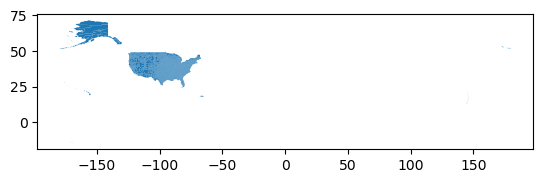

In [20]:
# d
# Plot the geo-dataframe
counties.plot()

In [21]:
# Check the type of each element in the geometry column
counties.geom_type

0       Polygon
1       Polygon
2       Polygon
3       Polygon
4       Polygon
         ...   
3230    Polygon
3231    Polygon
3232    Polygon
3233    Polygon
3234    Polygon
Length: 3235, dtype: object

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 6.B. Cleaning

Simplify column names as needed.

In [22]:
# Convert column names to lowercase
counties.columns = counties.columns.str.lower()

# Confirm result
print(counties.columns)

Index(['statefp', 'countyfp', 'countyns', 'geoid', 'geoidfq', 'name',
       'namelsad', 'lsad', 'classfp', 'mtfcc', 'csafp', 'cbsafp', 'metdivfp',
       'funcstat', 'aland', 'awater', 'intptlat', 'intptlon', 'geometry'],
      dtype='object')


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 6.C. Data selection

Select all the counties for the state of New York in a new variable `ny_counties` and plot them (you may need to look at the metadata).

<Axes: >

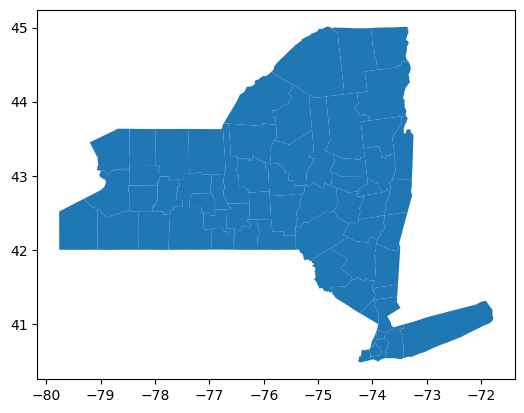

In [23]:
# Select the counties in New York using corresponding FIPS code
ny_counties = counties[counties['statefp'] == '36']

# Plot counties to confirm filtering
ny_counties.plot()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 7 Merging

The goal of this section is to create a single dataframe with the number of spills per county and the corresponding geometries for each county.

### 7.A. Explore data

In the next cells:

a. Print the names of counties in `ny_counties`, without repetition.


In [24]:
# Print unique county names in ny_counties
counties_unique = ny_counties.name.unique()
print(counties_unique)

['Steuben' 'Saratoga' 'Allegany' 'Oswego' 'Ulster' 'St. Lawrence'
 'Schuyler' 'Essex' 'Suffolk' 'Hamilton' 'Dutchess' 'Otsego' 'Tompkins'
 'Albany' 'Cayuga' 'Greene' 'Herkimer' 'Warren' 'Jefferson' 'Clinton'
 'Nassau' 'Madison' 'Washington' 'Westchester' 'Lewis' 'Ontario'
 'Cortland' 'Richmond' 'Erie' 'Putnam' 'Montgomery' 'Sullivan' 'Orleans'
 'Oneida' 'Cattaraugus' 'Yates' 'Tioga' 'Monroe' 'Schoharie' 'Broome'
 'Rensselaer' 'Seneca' 'Queens' 'Genesee' 'Wayne' 'Niagara' 'Kings'
 'Chemung' 'Wyoming' 'New York' 'Columbia' 'Chautauqua' 'Franklin'
 'Onondaga' 'Chenango' 'Fulton' 'Rockland' 'Livingston' 'Delaware'
 'Orange' 'Schenectady' 'Bronx']


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Print the names of counties in `spills_per_county`, without repetition. Examine the differences in the outputs.

In [25]:
# Print unique county names in spills_per_county
spills_unique = spills_per_county.county.unique()
print(spills_unique)

['Albany' 'Allegany' 'Bronx' 'Broome' 'Cattaraugus' 'Cayuga' 'Chautauqua'
 'Chemung' 'Chenango' 'Clinton' 'Columbia' 'Cortland' 'Delaware'
 'Dutchess' 'Erie' 'Essex' 'Franklin' 'Fulton' 'Genesee' 'Greene'
 'Hamilton' 'Herkimer' 'Jefferson' 'Kings' 'Lewis' 'Livingston' 'Madison'
 'Monroe' 'Montgomery' 'Nassau' 'New Jersey - Region 2' 'New York'
 'Niagara' 'Oneida' 'Onondaga' 'Ontario' 'Orange' 'Orleans' 'Oswego'
 'Otsego' 'Putnam' 'Queens' 'Rensselaer' 'Richmond' 'Rockland' 'Saratoga'
 'Schenectady' 'Schoharie' 'Schuyler' 'Seneca' 'St Lawrence' 'Steuben'
 'Suffolk' 'Sullivan' 'Tioga' 'Tompkins' 'Tuscarora Indian Reservation'
 'Ulster' 'Warren' 'Washington' 'Wayne' 'Westchester' 'Wyoming' 'Yates']


<!-- END QUESTION -->



c. Which are the county names that are in `spills_per_county`, but not in `ny_counties`? Your answer should be a list of strings
HINT: You can use the `numpy` function [`setdiff1d()`](https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html), pay attention to the example in the documentation. Store your answer in the `diff_names` variable. 


In [26]:
# Find spills_per_county county names not in ny_counties and convert to type list
diff_names_spills = list(np.setdiff1d(spills_unique, counties_unique))
diff_names_spills

['New Jersey - Region 2', 'St Lawrence', 'Tuscarora Indian Reservation']

In [27]:
grader.check("7Ac")

7Ac results: All test cases passed!

d. Which are the county names that are in `ny_counties`, but not in `spills_per_county`? Your answer should be a list of strings.


In [28]:
# Find ny_counties county names not in spills_per_county and convert to type list
diff_names_ny = list(np.setdiff1d(counties_unique, spills_unique))
diff_names_ny

['St. Lawrence']

In [29]:
grader.check("7Ad")

7Ad results: All test cases passed!

e. What is the number of spills in 'Tuscarora Indian Reservation'?


In [30]:
# e. 

# Get row in spills_per_county associated with Tuscarora Indian Reservation 
tir_row = spills_per_county.loc[spills_per_county['county'] == 'Tuscarora Indian Reservation', 'n_spills']

# Print value in n_spills column of row
print(f"There was {tir_row.iloc[0]} spill in the Tuscarora Indian Reservation.")

There was 1 spill in the Tuscarora Indian Reservation.


### 7.B. Data updates

In the next cell, update 'St Lawrence' to 'St. Lawrence' in `spills_per_county` data frame and Verify the update was successful.


In [31]:
# Correct 'St Lawrence' to 'St. Lawrence'
spills_per_county['county'] = spills_per_county['county'].replace('St Lawrence', 'St. Lawrence')

# Confirm value was updated
spills_per_county.loc[spills_per_county['county'] == 'St. Lawrence', 'county']

50    St. Lawrence
Name: county, dtype: object

### 7.C. Merge

In the following cells:

a. Use this cell to make any other updates needed for making an inner join of the `spills_per_county` and `ny_counties`. 


In [32]:
# Rename columns containing county names for inner join
ny_counties = ny_counties.rename(columns = {'name':'county'})

b. Over-write `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.


In [33]:
# Inner join to merge ny_counties and spills_per_county data frames
ny_counties = pd.merge(ny_counties,
                       spills_per_county,
                       how='inner',
                       on='county')

# Confirm result
ny_counties.head()

,statefp,countyfp,countyns,geoid,geoidfq,county,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry,n_spills
0,36,101,00974148,36101,0500000US36101,Steuben,Steuben County,06,H1,G4020,236,18500,None,A,3601398422,35039875,+42.2667252,-077.3855253,"POLYGON ((-77.08327 42.00002, -77.09391 41.999...",72
1,36,091,00974143,36091,0500000US36091,Saratoga,Saratoga County,06,H1,G4020,104,10580,None,A,2097812305,87488004,+43.1061353,-073.8553872,"POLYGON ((-73.67891 42.91221, -73.67938 42.911...",162
2,36,003,00974100,36003,0500000US36003,Allegany,Allegany County,06,H1,G4020,None,None,None,A,2666409356,12990521,+42.2478532,-078.0261531,"POLYGON ((-78.04342 42.51846, -78.04326 42.518...",30
3,36,075,00974136,36075,0500000US36075,Oswego,Oswego County,06,H1,G4020,532,45060,None,A,2464650884,933469962,+43.4614431,-076.2092618,"POLYGON ((-76.02509 43.70702, -76.02004 43.706...",68
4,36,111,00974153,36111,0500000US36111,Ulster,Ulster County,06,H1,G4020,408,28740,None,A,2911757764,94596810,+41.9472124,-074.2654582,"POLYGON ((-74.07480 42.09659, -74.06441 42.120...",162



From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. Tuscarora Indian Reservation is located within Niagara county. 

c. Since the Tuscarora Indian Reservation does not appear in the `ny_counties` dataframe, add one spill to Niagara county. We will add a note about this in our final map. Add the cells you need to make this update **and** verify that the dataframe was updated.

In [34]:
# Check that Tuscarora Indian Reservation is nowhere in data frame
print(f"In data frame? {'Tuscarora Indian Reservation' in ny_counties.values}")

# Get index of row with Niagara county
n_index = ny_counties[ny_counties['county']=='Niagara'].index
n_index

In data frame? False


Index([45], dtype='int64')

In [35]:
# Check initial value
ny_counties.loc[n_index, 'n_spills']

45    88
Name: n_spills, dtype: int64

In [36]:
# Update Niagara county spills by directly adding 1
ny_counties.loc[n_index, 'n_spills'] += 1

In [37]:
# Confirm result
ny_counties.loc[n_index, 'n_spills']

45    89
Name: n_spills, dtype: int64

## 8. Map
a. Create a choropleth map of the number of petroleum spills per county in the state of New York in 2023. 
Your map should be polished and have (at least) the following updates:
- a legend indicating the number of spills
- an updated color map
- a title 
- no axis
- an annotation with the data source (New York State Department of Environmental Conservation) and date of access



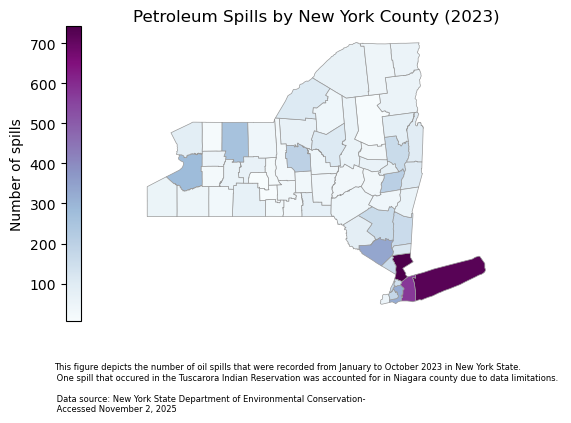

In [38]:
# Create choropleth map to visualize number of spills per county
fig, ax = plt.subplots()

ax.set_title("Petroleum Spills by New York County (2023)")
ax.axis("off")

# Plot merged data frame and color counties by n_spills
ny_counties.plot(ax=ax,
                column = 'n_spills',
                cmap = 'BuPu',
                legend = True,
                edgecolor = "0.6",
                linewidth = 0.5,
                legend_kwds = {
                    "label": "Number of spills",
                    "location": "left",
                    "shrink": 0.8
                }
                )

# Add data source
plt.figtext(0.2, 0, "This figure depicts the number of oil spills that were recorded from January to October 2023 in New York State. \n One spill that occured in the Tuscarora Indian Reservation was accounted for in Niagara county due to data limitations. \n \n Data source: New York State Department of Environmental Conservation- \n Accessed November 2, 2025", fontsize = 6)
plt.show()

b. Write a description of how the map was created, including key takeaways. If you need to do additional data analysis to include relevant information from the data, you may include additional cells here.

In [39]:
# Check the counties with the top 5 most spills 
ny_counties.sort_values('n_spills', ascending = False).head()

,statefp,countyfp,countyns,geoid,geoidfq,county,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry,n_spills
23,36,119,00974157,36119,0500000US36119,Westchester,Westchester County,06,H1,G4020,408,35620,35614,A,1115811940,179391718,+41.1526862,-073.7457526,"POLYGON ((-73.65762 40.98550, -73.65739 40.985...",744
8,36,103,00974149,36103,0500000US36103,Suffolk,Suffolk County,06,H1,G4020,408,35620,35004,A,2359277313,3787417976,+40.9435540,-072.6922183,"POLYGON ((-71.80938 41.20323, -71.79115 41.184...",723
20,36,059,00974128,36059,0500000US36059,Nassau,Nassau County,06,H1,G4020,408,35620,35004,A,736960644,437290665,+40.7296118,-073.5894144,"POLYGON ((-73.78019 40.82640, -73.77498 40.830...",576
59,36,071,00974134,36071,0500000US36071,Orange,Orange County,06,H1,G4020,408,28880,None,A,2103272841,67953621,+41.4024096,-074.3062522,"POLYGON ((-74.24491 41.60376, -74.24456 41.603...",336
42,36,081,00974139,36081,0500000US36081,Queens,Queens County,06,H6,G4020,408,35620,35614,C,281594053,188444349,+40.6546581,-073.8412089,"POLYGON ((-74.03813 40.53829, -74.03749 40.542...",321


This map was created using matplotlib, so using a figure and an axis. The merged geo-dataframe 'ny_counties' was plotted, as this contained both the New York county geometries and the number of spills associated with each one. Various customizations were done, such as selecting an appropriate color palette for the column `n_spills` and moving the legend to better space out the map and figure text using legend keyword arguments.

The darkest counties with 500-700 recorded oil spills during January to October of 2023 were located in the more populated areas of New York (near the city) but also on the coastline or by water. Upstate New York experienced significantly less oil spills.

## Complete workflow

**STILL WORKING ON THIS**

Collect all the relevant code into a **new notebook** titled `hwk3-task1-spills-COMPLETE-YOURLASTNAME.ipynb`. This notebook should have two sections:the a single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The *only* ouput of this cell should be the graph you produced in the previous exercise. Further guidance on what to include in this final workflow is in the assignment rubric.



**From last HW:**

Collect all the relevant code into the first blank cell of the notebook titled "COMPLETE WORKFLOW". This single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The only ouput of this cell should be the graph you produced in the previous exercise. Further guidance on what to include in this final workflow is in the assignment rubric.

##### Run the cell below to run all autograder tests. 

In [40]:
grader.check_all()

7Ac results: All test cases passed!

7Ad results: All test cases passed!

q5d results:
    q5d - 1 result:
        ❌ Test case failed
        Trying:
            def test_q3(student_data):
                try:
                    expected_data = pd.read_csv('data/q5d_df.csv').drop(columns='Unnamed: 0')
                    pd.testing.assert_frame_equal(expected_data, student_data)
                except AssertionError:
                    raise AssertionError('Incorrect answer.')
        Expecting nothing
        ok
        Trying:
            test_q3(spills_per_county)
        Expecting nothing
        **********************************************************************
        Line 7, in q5d 0
        Failed example:
            test_q3(spills_per_county)
        Exception raised:
            Traceback (most recent call last):
              File "<doctest q5d 0[0]>", line 4, in test_q3
                pd.testing.assert_frame_equal(expected_data, student_data)
              File "/op